#  Instrument variable

### Økonometri A (ØkA)

Bertel Schjerning

Department of Economics, University of Copenhagen


### Enable autoreload

In [1]:
# Sørger for at alle importerede python filer geninlæses ved import statements
# Nødvedigt, hvis ændinger skal tage effekt uden at genstarte Python Kernel
%load_ext autoreload
%autoreload 2

# Part 1: IV estimation (løn regression)

### Indlæs data og moduler

In [2]:
import pandas as pd
import numpy as np
import mymlr as mlr  

# Indlæs data og opret variabler
df_mroz = pd.read_stata("../data/mroz.dta")   # Indlæs data fra en Stata-fil
df_mroz['const'] = 1  # Tilføj en konstant term (intercept)
df_mroz['lwage'] = np.log(df_mroz['wage'])  # Logaritmer lønvariablen 'wage'
df = df_mroz.dropna(subset='lwage')  # Fjern rækker med manglende værdier i 'lwage'

### Sammenlign OLS og IV

In [3]:
# OLS
m_ols = mlr.ols(X=df[['const', 'educ']], y=df['lwage'])  # Estimér OLS-model

# IVE med 'motheduc' som instrument
m_2sls = mlr.tsls(y=df['lwage'], 
                  X1=df[['const']], 
                  X2=df[['educ']], 
                  Ze=df[['motheduc']]) 

mlr.summary([m_ols, m_2sls], column_titles=["OLS", "IV"], report_stats="t")

                         OLS       IV
Dependent variable   [lwage]  [lwage]
             const   -0.1852   0.7022
                   (-0.9998) (1.4475)
              educ    0.1086   0.0385
                    (7.5451) (1.0084)
         R_squared    0.1179   0.0688
               TSS  223.3274 223.3274
               RSS  197.0010 207.9598
               ESS   26.3264  15.3676
                 n       428      428
Note: t-statistics are reported in parentheses.



### OLS/IV: Simpel implemtering med en forklarende variable og et instrument 

In [4]:
cov=df[['lwage','educ', 'motheduc']].cov()
b_OLS=cov.loc['lwage', 'educ']/cov.loc['educ','educ']
b_IV=cov.loc['lwage', 'motheduc']/cov.loc['educ', 'motheduc']
print(f'Covariance matrix\n {cov}\n')
print(f'b_OLS (educ) {b_OLS.round(4)}')
print(f'b_IV  (educ) {b_IV.round(4)}')
mlr.summary([m_ols, m_2sls], column_titles=["OLS", "IV"], report_stats="t")


Covariance matrix
              lwage      educ   motheduc
lwage     0.523015  0.567466   0.112796
educ      0.567466  5.222942   2.925967
motheduc  0.112796  2.925967  10.943526

b_OLS (educ) 0.1086
b_IV  (educ) 0.0385
                         OLS       IV
Dependent variable   [lwage]  [lwage]
             const   -0.1852   0.7022
                   (-0.9998) (1.4475)
              educ    0.1086   0.0385
                    (7.5451) (1.0084)
         R_squared    0.1179   0.0688
               TSS  223.3274 223.3274
               RSS  197.0010 207.9598
               ESS   26.3264  15.3676
                 n       428      428
Note: t-statistics are reported in parentheses.



### IV som effekten af $z$ på $y$ relativt til effekten af $z$ på $x$

In [5]:
# First stage (effekt af z på x)
m_first = mlr.ols(y=df['educ'], X=df[['const', 'motheduc']])  

# Reduceret form (effekt af z på y)
m_reduced = mlr.ols(y=df['lwage'], X=df[['const', 'motheduc']])  

b_2SLS=m_reduced['beta_hat'][1]/m_first['beta_hat'][1]
print(f'b_IV   (educ) {b_IV.round(4)}')
print(f'b_2SLS (educ) {b_2SLS[0].round(4)}')


b_IV   (educ) 0.0385
b_2SLS (educ) 0.0385


# Part 2: Konsistens, bias, asymptotisk fordeling for IV


## Sammenligning af OLS og IV 
### IV estimatoren er konsistent, men ikke middelret

Vi undersøger fordelingen af OLS og IV, afhængigt af stikprøvestørrelsen $(n)$.

### Model:
$$
\begin{align*}
    y &= x\beta + u \\
    x &= \rho_{xz}z + \rho_{xu} u + \varepsilon \\
    z &\sim N(0,1), \quad u \sim N(0,1), \quad \varepsilon \sim N(0,1)
\end{align*}
$$

### Grænseværdi:
$$
\begin{align*}
	\text{plim}\left(\hat{\beta}_1^{IV} \right)  &= \beta_{1} + \frac{cov(u,z)}{cov(x,z)} = \beta_{1} \\
	\text{plim}\left(\hat{\beta}_1^{OLS} \right) 
    &= \beta_{1}+ \frac{cov(u,x)}{var(x)}
    = \beta_{1}+\frac{cov(u, z + \rho_{xu} u + \varepsilon)}{var(\rho_{zu}z + \rho_{xu} u + \varepsilon)} 
    = \beta_{1}+\frac{\rho_{xz}}{\rho_{xz}+\rho_{xu}+1}
	\end{align*}
$$


### Monte Carlo
Simuler modellen 2.000 gange med $n \in \{25, 100, 1000\}$.

### Simulator


In [6]:
def simulate(n=100, beta=1, sigma_z=1, sigma_u=1, sigma_e=1, rho_xu=0,rho_xz=0):
    norm=np.random.normal
    const = np.ones(n)
    z = norm(0, sigma_z, size=n)  # Instrument
    u = norm(0, sigma_u, size=n)  # Fejlled i ligning for y
    e = norm(0, sigma_e, size=n)  # Fejlled i ligning for x
    x = rho_xz*z + rho_xu*u + e;  # x-variabel
    
    y = beta * x + u   # Strukturel ligning 
    
    # Dataframes for udvalgte og fulde sample
    df = pd.DataFrame({'y': y, 'const': const, 'x': x, 'z': z, 'u': u, 'e': e})

    return df

### Monte Carlo simulator

In [7]:
import monte_carlo as mc
IV= lambda df: mlr.tsls(y=df['y'], X1=df[['const']], X2=df[['x']], Ze=df[['z']])  
OLS= lambda df: mlr.ols(X=df[['const', 'x']], y=df['y'])
def monte_carlo1( 
                 rho_xz=1, # Try lovering rho_xz to make instrument weaker
                 rho_xu=1, # Endogeneity of x
                 n=100     # Sample size
    ): 
    print(f'Plim IV = 1,  Plim OLS = {round(1+rho_xu/(1+rho_xu+rho_xz),4)}')
    sim1 = lambda: simulate(n, rho_xz=rho_xz,rho_xu=rho_xu)
    b_ols, se_ols = mc.simulate(sim1, estimator=OLS, S=2000)
    b_iv, se_iv = mc.simulate(sim1, estimator=IV, S=2000)
    b = pd.DataFrame({f'ols': b_ols['x'],'iv': b_iv['x']})
    se = pd.DataFrame({'ols': se_ols['x'],'iv': se_iv['x']})
    mc.histogram(stat=b, bins=50, truestat=[1,1], title=f'Sample size, n={n}');
    mc.summary_table(b,se, beta0=[1,1])

### Do the Monte Carlo

Plim IV = 1,  Plim OLS = 1.3333


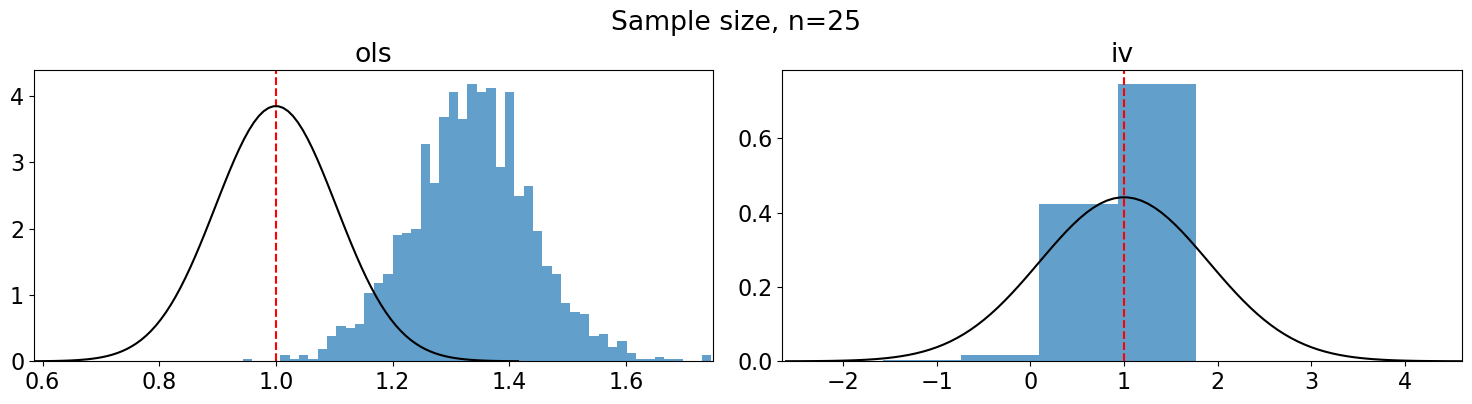

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,1.334996,0.103716,0.097958
iv,iv,1,0.961114,0.903244,0.528438


Plim IV = 1,  Plim OLS = 1.3333


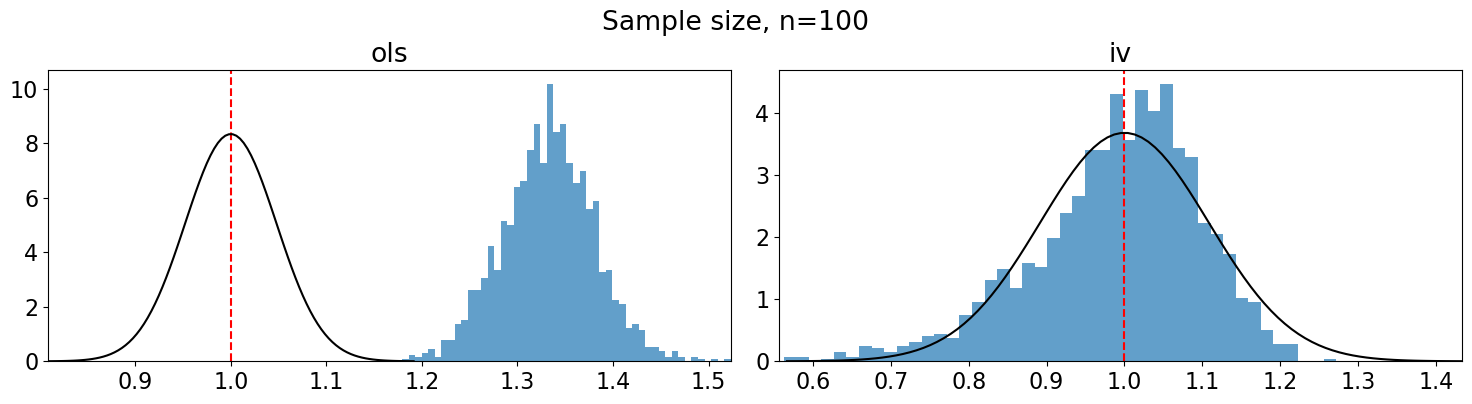

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,1.332231,0.047839,0.047852
iv,iv,1,0.989715,0.108400,0.106515


Plim IV = 1,  Plim OLS = 1.3333


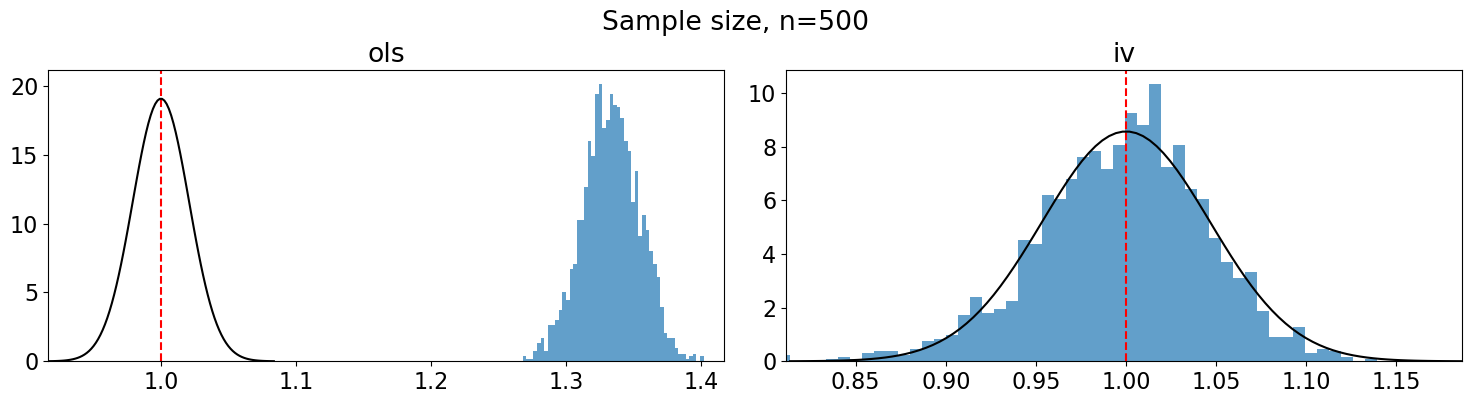

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,1.333508,0.020921,0.021119
iv,iv,1,0.997705,0.046595,0.045203


In [8]:
rho_xz =1 # Try lovering rho_xz to make instrument weaker
# rho_xz = .2 # Try lovering rho_xz to make instrument weaker
for n in [25,100,500]: 
    monte_carlo1(rho_xz=rho_xz, rho_xu=1, n=n)

## Konklusion part 2: Konsistens, bias, asymptotisk fordeling for IV
- OLS er inkonsistent, da $cov(u,x)\ne 0)$
- IV er konsistent og asymptotisk normalfordelt
- IV er ikke middelret i endelige stikprøver (finite sample bias)
- IV har større vaians end OLS
- Lille $n$ og lille $cov(x,z)$ (svage instrumenter) $\rightarrow $ finite sample bias selv i større stikprøver
- IV er asymptotisk normalfordelt og konsistent, men med svage instrumenter kræves stor stikprøve, $n$ 


## Part 3: IV som løsning på målefejl

### Model
$$
y=\beta_{0}+\beta_{1}x^{*}+u
\\	x=x^{*}+e \quad (x^{*} \text{med målefejl 1})
\\	z = x^{*} + \nu \quad (x^{*} \text{med målefejl 2})
\\ u~\sim N(0, \sigma_u^2), \quad x^*~\sim N(\mu_x, \sigma_x^2), \quad e~\sim N(0, \sigma_e^2), \quad \nu~\sim N(0, \sigma_{\nu}^2)
$$

- Vi burger $z$ som instrument for $x$ og kan dermed konsistent estimere $\beta_{1}$ med IV

### Simulator


In [9]:
def sim_merror(n=100, beta=1, mu_x=1, sigma_x=1, sigma_u=1, sigma_e=1, sigma_v=1):
    norm=np.random.normal

    const = np.ones(n)
    xstar = norm(mu_x, sigma_x, size=n);  # Endogenous variable 
    e = norm(0, sigma_e, size=n) # målefejl 1 
    v = norm(0, sigma_v, size=n) # målefejl 2 
    x = xstar + e # x med målefejl 1
    z = xstar + v # instrument: x men målefejl 2
    u = norm(0, sigma_u, size=n)  
    
    y = beta * xstar + u   # Strukturel ligning 
    
    # Dataframes for udvalgte og fulde sample
    df = pd.DataFrame({'y': y, 'const': const, 'x': x, 'z': z})

    return df

### Monte carlo


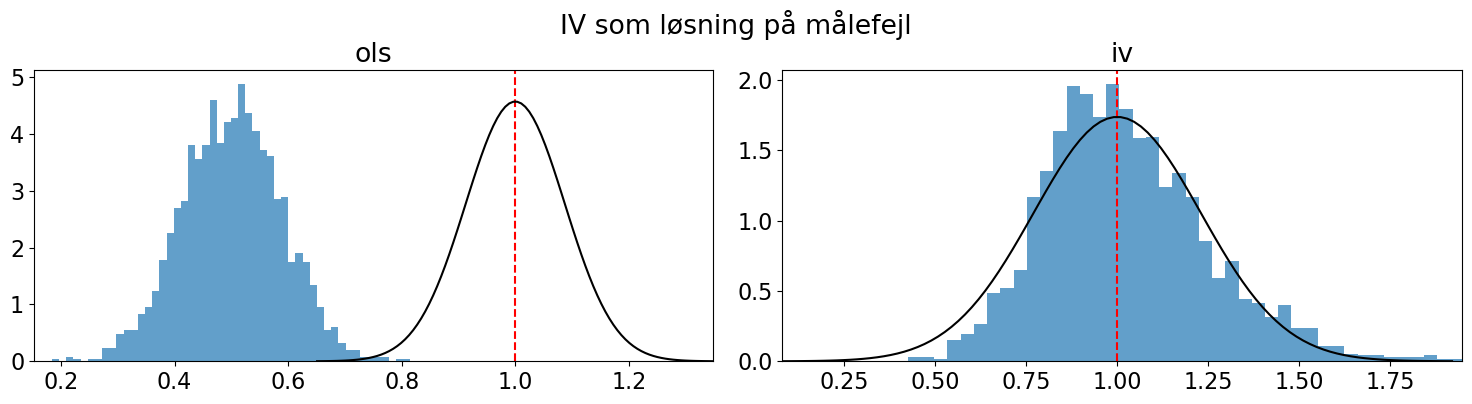

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,0.501247,0.087253,0.087525
iv,iv,1,1.027316,0.229734,0.219175


In [10]:
b_ols, se_ols = mc.simulate(sim_merror, estimator=OLS, S=2000)
b_iv, se_iv = mc.simulate(sim_merror, estimator=IV, S=2000)
b = pd.DataFrame({f'ols': b_ols['x'],'iv': b_iv['x']})
se = pd.DataFrame({'ols': se_ols['x'],'iv': se_iv['x']})
mc.histogram(stat=b, bins=50, truestat=[1,1], title=f'IV som løsning på målefejl');
mc.summary_table(b,se, beta0=[1,1])

## Konklusion part 3: IV som løsning på målefejl
- OLS er inkonsistent, da $cov(u,x)\ne 0)$ 
- Atenuation bias: plim $\hat{\beta}_1^{OLS} = \beta_1 \frac{\sigma_{x}^2}{\sigma_{x}^2+\sigma_{e}^2}= \beta_1\frac{1}{2}=\frac{1}{2}<\beta_1$
- IV er konsistent, asymptotisk normalfordelt men har større vaians end OLS


# Part 4: Løn regression med flere IVs
- Two Stage Least Squares (2SLS) med flere instrumenter 
- Test for styrke af instrumenter (F-test)

### Model
$$		\begin{align*}
			\log (wage)&=\beta _{0}+\beta _{1}age+\beta _{2}exper+\beta_{3}exper^{2}+\beta _{4}educ+u	\\educ&=\pi _{0}+\pi_{1}age+\pi _{2}exp
			+\pi_{3}exp^{2} 
			 + \pi_{4}motheduc+\pi _{5}fatheduc+v
			\end{align*}
$$

- Exogene variable ($X_1$): Konstant, age, exper, exper$^2$
- Endogen variabel ($X_2$): Uddannelse (educ)
- Instrumenter ($Z_e$): Mors og fars uddannelse (motheduc, fatheduc)
- F-test for styrke af instrumenter i first stage ($H_{0}:\pi_{4}=\pi_{5}=0$)


## Part 4a: Two Stage Least Squares (2SLS) med flere instrumenter 

### Indlæs mroz data og definer variable

In [11]:
# Indlæs mroz data igen (og fjern missings)
import mymlr as mlr
df = df_mroz.dropna(subset='lwage')  # Fjern rækker med manglende værdier i 'lwage'
y=df['lwage']  # Dependent variable
X1=df[['const', 'age', 'exper', 'expersq']] # Exgogenous explanatroy variables
X2=df['educ'] # Endogenous explanatroy variables
Ze=df[['motheduc','fatheduc']]
Z=pd.concat([X1, Ze], axis=1)
X=pd.concat([X1, X2], axis=1)

### 2 Stage Least Squares som 2xOLS

In [12]:
# OLS
m_ols = mlr.ols(y=y, X=X)  
# First stage regression
m_stage1 = mlr.ols(y=X2, X=Z) 
# Second stage regression 
X_hat=X1.copy()
X_hat['educ_hat']=m_stage1['y_hat']
m_stage2 = mlr.ols(y=y, X=X_hat)

mlr.summary([m_ols, m_stage1, m_stage2], column_titles=["OLS", "Stage 1", "Stage 2"], report_stats="se")

                        OLS   Stage 1  Stage 2
Dependent variable  [lwage]    [educ]  [lwage]
             const  -0.5334    8.8511   0.0667
                   (0.2778)  (0.7626) (0.4813)
               age   0.0003    0.0060  -0.0004
                   (0.0049)  (0.0151) (0.0052)
             exper   0.0416    0.0451   0.0442
                   (0.0132)  (0.0403) (0.0141)
           expersq  -0.0008   -0.0011  -0.0009
                   (0.0004)  (0.0012) (0.0004)
              educ   0.1075                   
                   (0.0142)                   
          motheduc             0.1604         
                             (0.0366)         
          fatheduc             0.1886         
                             (0.0339)         
          educ_hat                      0.0610
                                      (0.0331)
         R_squared   0.1568    0.2118   0.0498
               TSS 223.3274 2230.1963 223.3274
               RSS 188.3036 1757.9153 212.2162
             

### 2SLS med korrekte standardfejl (se tsls i mymlr.py)
**2SLS estimator** 
\begin{align*}
\hat{\beta}^{2SLS} = (\mathbf{X}'\mathbf{P_Z}\mathbf{X})^{-1} (\mathbf{X}'\mathbf{P_Z}\mathbf{y})
= (\hat{\mathbf{X}}' \hat{\mathbf{X}})^{-1} \hat{\mathbf{X}}' \mathbf{y}  
\end{align*}
hvor $\hat{\mathbf{X}}=\mathbf{P_Z}\mathbf{X}$ er de predikterede værdier fra first stage og $\mathbf{P_Z} = \mathbf{Z}(\mathbf{Z}'\mathbf{Z})^{-1}\mathbf{Z}'$ er en projektionsmatrix 

**Varians for 2SLS estimator**

Med heteroskedasticitet:
		\begin{equation*}
		\widehat{\text{var}}(\hat{\beta}^{2SLS}|\mathbf{Z}, \mathbf{X}) = n(\hat{\mathbf{X}}'\hat{\mathbf{X}})^{-1} \hat{\boldsymbol{\Sigma}} (\hat{\mathbf{X}}'\hat{\mathbf{X}})^{-1}
		\end{equation*}
		hvor 
$$\hat{\boldsymbol\Sigma} = \frac{1}{n}\sum_i \hat{u}_i^2 \hat{\mathbf{x}}_i' \hat{\mathbf{x}}_i 
\text{ og } \hat{\mathbf{u}}=\mathbf{y}-{\mathbf{X}}\hat{\beta}^{2SLS}$$
Med homoskedasticitet:
\begin{equation*}
		\widehat{\text{var}}(\hat{\beta}^{2SLS}|\mathbf{Z}, \mathbf{X}) = \hat{\sigma}^{2}(\hat{\mathbf{X}}'\hat{\mathbf{X}})^{-1}
		\end{equation*}



### Sammenlign OLS, 2SLS (forskellige instrumenter) og stage 2 fra 2xOLS

In [13]:
# Estimér OLS-model
X=pd.concat([X1, X2], axis=1)
m_ols = mlr.ols(y,X)  
# 2SLS med 'motheduc' og/eller 'fatheduc' som instrument
m_2sls_m = mlr.tsls(y=y, X1=X1, X2=X2, Ze=df[['motheduc']])  
m_2sls_mf = mlr.tsls(y=y, X1=X1, X2=X2, Ze=df[['motheduc','fatheduc']])  
m_2sls_f = mlr.tsls(y=y, X1=X1, X2=X2, Ze=df[['fatheduc']])  
mlr.summary([m_ols, m_2sls_m, m_2sls_f, m_2sls_mf, m_stage2]
            , column_titles=["OLS", "2SLS(mother)", "2SLS(father)", "2SLS(both)", "Stage2(both)"], report_stats="se")

                        OLS 2SLS(mother) 2SLS(father) 2SLS(both) Stage2(both)
Dependent variable  [lwage]      [lwage]      [lwage]    [lwage]      [lwage]
             const  -0.5334       0.2278      -0.0514     0.0667       0.0667
                   (0.2778)     (0.5294)     (0.4937)   (0.4591)     (0.4813)
               age   0.0003      -0.0005      -0.0002    -0.0004      -0.0004
                   (0.0049)     (0.0050)     (0.0049)   (0.0049)     (0.0052)
             exper   0.0416       0.0449       0.0437     0.0442       0.0442
                   (0.0132)     (0.0136)     (0.0134)   (0.0135)     (0.0141)
           expersq  -0.0008      -0.0009      -0.0009    -0.0009      -0.0009
                   (0.0004)     (0.0004)     (0.0004)   (0.0004)     (0.0004)
              educ   0.1075       0.0485       0.0701     0.0610             
                   (0.0142)     (0.0376)     (0.0346)   (0.0316)             
          educ_hat                                              

### Bemærkninger til Part 4a
1. Sammenligning af *educ* for 2SLS(both) og *educ\_hat* i Trin 2
    - **Parameter estimater er *identiske*** (2SLS kan opnås ved OLS i 2 trin)
    - **Standardfejl i trin 2 *undervurderes***, hvis andet OLS-trin udføres mekanisk med sædvanlige residualer, $\hat{\mathbf{u}} = \mathbf{y} - \hat{\mathbf{X}}\hat{\beta}^{2SLS}$.
    - Korrekt varians beregnes med residualerne: $\hat{\mathbf{u}} = \mathbf{y} - \mathbf{X}\hat{\beta}^{2SLS}$ 
    <br>(korrekt i 2SLS(mother), 2SLS(father) og 2SLS(both)).
2. **Standardfejlene for 2SLS er typisk større end for OLS** 
    - **Svage instrumenter**: instrumentering $\rightarrow $ mindre variation i *educ_hat* $\rightarrow $ større vaians på $\hat{\beta}^{2SLS}$
    - **Stærke instrumenter** mindre varians på $\hat{\beta}^{2SLS}$
3. IV-estimaterne er lavere end OLS-estimaterne for afkast til uddannelse.
4. Hvis instrumenterne er *eksogene* og *stærke*, er IV en **konsistent estimator**.

## Part 4b: Test for styrke af instrumenter (F-test)

### Test for styrke af instrumenter (F-test)
- **Stærke instrumenter** mindsker variansen af 2SLS-estimatorerne
- Vi kan teste stryken af de enkelte instrimenter ved t-test i first stage 
- Test for samlet styrke af alle instrumenter udføres ved standard F-test for om $Z_e$ er signifikant i first stage ($H_{0}:\pi_{4}=\pi_{5}=0$)
<br> F-test implementeret i $\texttt{mlr.first_stage}$.

In [14]:
results = mlr.first_stage(y=y, X1=X1, X2=X2, Ze=Ze, robust=False, quiet=False)

First Stage for educ, Dependent Variable: ['educ']
Number of Observations: 428
Degrees of Freedom: 422 (Residual), 6 (Model)
R-squared: 0.2118
TSS: 2230.1963, RSS: 1757.9153, ESS: 472.2810
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
--------------------------------------------------------------------------------------------------
const                        8.8511         0.7626     11.6067      0.0000   [  7.3522, 10.3501 ]
age                          0.0060         0.0151      0.3980      0.6908   [ -0.0237, 0.0358  ]
exper                        0.0451         0.0403      1.1200      0.2633   [ -0.0341, 0.1243  ]
expersq                     -0.0011         0.0012     -0.8928      0.3725   [ -0.0035, 0.0013  ]
motheduc                     0.1604         0.0366      4.3795      0.0000   [  0.0884, 0.2325  ]
fatheduc                     0.1886         0.0339      5.5698      0.0000   [  0.1221, 0.2552  ]
F-test for joint significan

##  Bemærkninger til Part 4a

###  Instrumenterne er relevante 
- Begge instrumenter er signifikante hver for sig (t-stat>1.96) 
- F-test afvises (instrumenter er samlet set signifikante)

### Men er de valide?
- Vi mangler at teste om instrumenterne er valide $\text{cov}(\mathbf{Ze,u})=0$
- Har vi flere instrumenter end endogene variable kan vi udføre for overidentifikation 
<br> (kommer senere)

### Flere instrumenter gør 2SLS estimaterne mere præcise
- Simulations studie nedenfor



## Part 4c: Flere stærke/svage instrumenter (Monte Carlo)

### Flere stærke eller svage instrumenter: Monte Carlo
### Model:
$$
\begin{align*}
    y &= x\beta + u \\
    x &= \rho_{zu} (z_1 + z_2 + z_3) + \rho_{xu} u + \varepsilon \\
    z &\sim N(0,\sigma_z), \quad u \sim N(0,\sigma_u), \quad \varepsilon \sim N(0,\sigma_{\varepsilon})
\end{align*}
$$
Parameteren $\rho_{zu}$ styrer styrken af instrumenterne

In [15]:
def simulate_mult_ivs(n=100, beta=1, sigma_z=1, sigma_u=1, sigma_e=1, rho_xu=0,rho_xz=0):
    norm=np.random.normal
    const = np.ones(n)
    z1 = norm(0, sigma_z, size=n)  # Instrument
    z2 = norm(0, sigma_z, size=n)  # Instrument
    z3 = norm(0, sigma_z, size=n)  # Instrument
    u = norm(0, sigma_u, size=n)  # Fejlled i ligning for y
    e = norm(0, sigma_e, size=n)  # Fejlled i ligning for x
    x = rho_xz*(z1+z2+z2) + rho_xu*u + e;  # x-variabel
    
    y = beta * x + u   # Strukturel ligning 
    
    # Dataframes for udvalgte og fulde sample
    df = pd.DataFrame({'y': y, 'const': const, 
                       'x': x, 'z1': z1, 'z2': z2, 'z3': z3, 
                       'u': u, 'e': e})

    return df

### Monte carlo rutine


In [16]:
import monte_carlo as mc
def monte_carlo_mult_iv(rho_xz=1,rho_xu=1, n=200, S=2000):
    OLS= lambda df: mlr.ols(X=df[['const', 'x']], y=df['y'])
    IV1= lambda df: mlr.tsls(y=df['y'], X1=df['const'], X2=df['x'], Ze=df['z1'])  
    IV2= lambda df: mlr.tsls(y=df['y'], X1=df['const'], X2=df['x'], Ze=df[['z1','z2']])  
    IV3= lambda df: mlr.tsls(y=df['y'], X1=df['const'], X2=df['x'], Ze=df[['z1','z2','z3']])  
    sim1 = lambda: simulate_mult_ivs(n, rho_xz=rho_xz,rho_xu=rho_xu)

    b_ols, se_ols = mc.simulate(sim1, estimator=OLS, S=S)
    b_iv1, se_iv1 = mc.simulate(sim1, estimator=IV1, S=S)
    b_iv2, se_iv2 = mc.simulate(sim1, estimator=IV2, S=S)
    b_iv3, se_iv3 = mc.simulate(sim1, estimator=IV3, S=S)
    b = pd.DataFrame({f'ols': b_ols['x'],'iv1': b_iv1['x'], 'iv2': b_iv2['x'], 'iv3': b_iv3['x']})
    se = pd.DataFrame({f'ols': se_ols['x'],'iv1': se_iv1['x'], 'iv2': se_iv2['x'], 'iv3': se_iv3['x']})
    mc.histogram(stat=b, bins=50, truestat=[1,1,1,1], title=f'Strength of instruments, rho_xz={rho_xz}');
    mc.summary_table(b,se, beta0=[1,1,1,1])

### Monte Carlo simulation: En eller flere *stræke* instrumenter

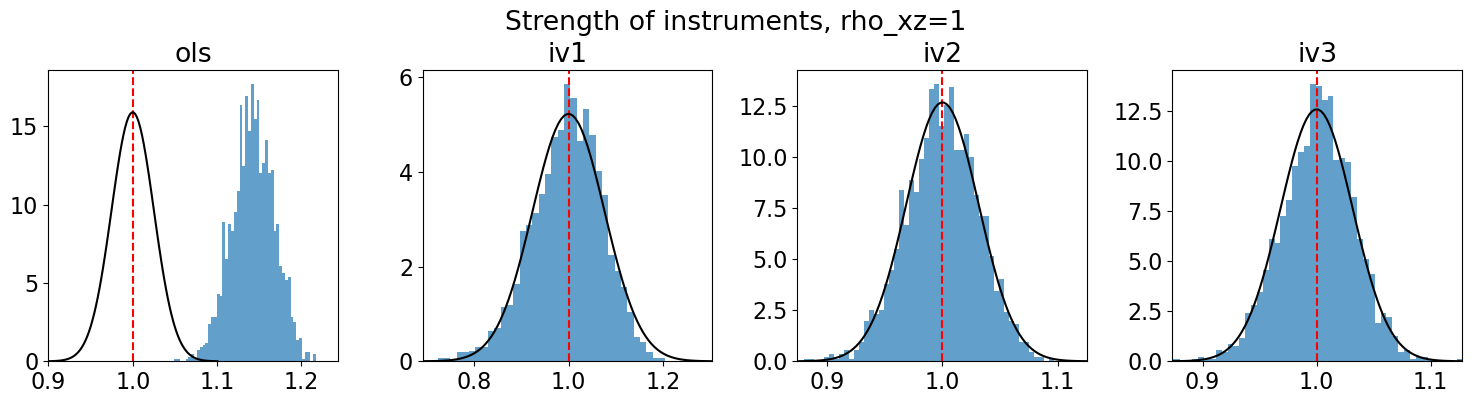

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,1.142585,0.025100,0.024905
iv1,iv1,1,0.996098,0.076372,0.075394
iv2,iv2,1,0.999883,0.031413,0.031890
iv3,iv3,1,1.000909,0.031667,0.031656


In [17]:
rho_xz=1; 
monte_carlo_mult_iv(rho_xz=rho_xz,rho_xu=1, n=200, S=2000) # Strong instruments

### Monte Carlo simulation: En eller flere *svage* instrumenter

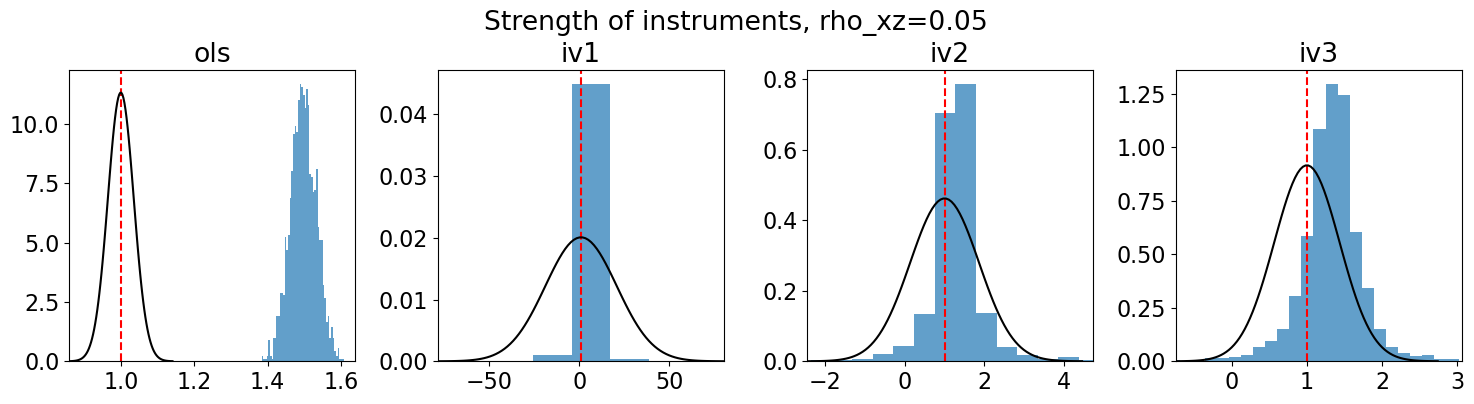

,Parameter,True Value,Mean Estimate,MC Standard Deviation,Average SE
ols,ols,1,1.497295,0.035226,0.035598
iv1,iv1,1,1.008636,19.873935,649.800460
iv2,iv2,1,1.274299,0.863716,1.128072
iv3,iv3,1,1.323080,0.435367,0.489218


In [18]:
rho_xz=.05
monte_carlo_mult_iv(rho_xz=rho_xz,rho_xu=1, n=200, S=2000) # Weak instruments

# Part 5: Test for eksogenitet af uddannelse


In [19]:
# Indlæs mroz data igen (og fjern missings)
df = df_mroz.dropna(subset=['lwage']).copy()  # Kopier for at undgå SettingWithCopyWarning
y = df['lwage']  # Afhængig variabel
X1 = df[['const', 'age', 'exper', 'expersq']]  # Eksogene forklarende variable
X2 = df['educ']  # Endogene forklarende variable
Ze = df[['motheduc', 'fatheduc']]  # Instrumenter

# Step 1: Udfør 2SLS regression (second stage) og gem residualer
m_2sls = mlr.tsls(y=y, X1=X1, X2=X2, Ze=Ze)
df['uhat'] = m_2sls['u_hat']  # Gem residualer fra second stage

# Step 2: Udfør first stage regression (regressér 'educ' på instrumenterne) og gem residualer
m_first_stage = mlr.ols(y=X2, X=pd.concat([Ze, X1], axis=1))
df.loc[:, 'Ehat'] = m_first_stage['u_hat']  # Gem residualer fra first stage

# Step 3: Test for eksogeneitet ved at regressere 'lwage' på 'age', 'exper', 'expersq', 'educ' og 'Ehat'
XEhat = pd.concat([X1, X2, df['Ehat']], axis=1)
m_exogeneity_test = mlr.ols(y=y, X=XEhat, quiet=False, title="Exogeneity Test Results")

Exogeneity Test Results, Dependent Variable: ['lwage']
Number of Observations: 428
Degrees of Freedom: 422 (Residual), 6 (Model)
R-squared: 0.1624
TSS: 223.3274, RSS: 187.0546, ESS: 36.2728
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
--------------------------------------------------------------------------------------------------
const                        0.0667         0.4524      0.1475      0.8828   [ -0.8225, 0.9560  ]
age                         -0.0004         0.0049     -0.0729      0.9419   [ -0.0099, 0.0092  ]
exper                        0.0442         0.0133      3.3341      0.0009   [  0.0181, 0.0703  ]
expersq                     -0.0009         0.0004     -2.2283      0.0264   [ -0.0017, -0.0001 ]
educ                         0.0610         0.0311      1.9601      0.0506   [ -0.0002, 0.1222  ]
Ehat                         0.0586         0.0349      1.6786      0.0940   [ -0.0100, 0.1273  ]


# Part 6: Test for eksogenitet af instrumenter (over identifikations test)


### Estimer med 2SLS og udfør Sargan test baseret på GMM kriterie 
Implementeret i mlr.tsls 

In [20]:
Ze = df[['motheduc', 'fatheduc']]  # Prøv 1 enstrument, hvad bliver J-stat?
# Udfør 2SLS regression (second stage)
m_2sls = mlr.tsls(y=y, X1=X1, X2=X2, Ze=Ze, quiet=False) # Udfører også Sargan test baseret på GMM kriterie

2SLS Regression Results, Dependent Variable: ['lwage']
Number of Observations: 428
Degrees of Freedom: 423 (Residual), 5 (Model)
R-squared: 0.1353
TSS: 223.3274, RSS: 193.1003, ESS: 30.2272
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
--------------------------------------------------------------------------------------------------
const                        0.0667         0.4591      0.1453      0.8845   [ -0.8357, 0.9691  ]
age                         -0.0004         0.0049     -0.0718      0.9428   [ -0.0100, 0.0093  ]
exper                        0.0442         0.0135      3.2854      0.0011   [  0.0178, 0.0706  ]
expersq                     -0.0009         0.0004     -2.1957      0.0287   [ -0.0017, -0.0001 ]
educ                         0.0610         0.0316      1.9314      0.0541   [ -0.0011, 0.1231  ]
Sargant test for overidentification, J=0.4020985073 ~ Chi2(1)
P-value for Sargan test: 0.5260



### Udfør Sargan test baseret på GMM kriterie 

In [21]:
# Estimér hjælperegressionen: regressér residualerne uhat på alle instrumenterne
from scipy.stats import chi2
df['uhat'] = m_2sls['u_hat'] 
m_sargan = mlr.ols(y=df['uhat'], X=pd.concat([Ze, X1], axis=1), quiet=False, title="Sargan Helperegression")

# Sargan-test: J = n * R² ~ Chi2(g-l) 
J_stat = m_sargan['n']* m_sargan['R_squared']
g = Ze.shape[1]  # Antal instrumenter
l = 1  # Antal endogene variable
p_value = 1 - chi2.cdf(J_stat, df=g - l)  # p-værdi for teststørrelsen

print(0.1814/(193.1003/428))
# Udskriv resultatet
print(f"Sargan-teststatistik, J~Chi2({g - l}): {J_stat:.10f}")
print(f"P-værdi: {p_value:.4f}")
if p_value < 0.05:
    print("Vi forkaster H_0: Instrumenterne er ugyldige.")
else:
    print("Vi kan ikke afvise H_0: Instrumenterne er muligvis gyldige.")

Sargan Helperegression, Dependent Variable: ['uhat']
Number of Observations: 428
Degrees of Freedom: 422 (Residual), 6 (Model)
R-squared: 0.0009
TSS: 193.1003, RSS: 192.9188, ESS: 0.1814
Variable                Coefficient     Std. Error           t       P>|t|    95% Conf. Interval
--------------------------------------------------------------------------------------------------
motheduc                    -0.0069         0.0121     -0.5723      0.5674   [ -0.0308, 0.0169  ]
fatheduc                     0.0060         0.0112      0.5337      0.5939   [ -0.0161, 0.0280  ]
const                        0.0316         0.2526      0.1250      0.9006   [ -0.4650, 0.5282  ]
age                         -0.0005         0.0050     -0.0994      0.9209   [ -0.0104, 0.0094  ]
exper                       -0.0000         0.0133     -0.0009      0.9993   [ -0.0262, 0.0262  ]
expersq                      0.0000         0.0004      0.0189      0.9850   [ -0.0008, 0.0008  ]
0.40206669798027245
Sargan-te